In [40]:
# Big thanks to Eligijus Bujokas, who designed the DeepModelTS class. Link to his Towards Data Science article about it is below:
# https://towardsdatascience.com/energy-consumption-time-series-forecasting-with-python-and-lstm-deep-learning-model-7952e2f9a796 

# Data wrangling
import pandas as pd
import numpy as np

# Deep learning: 
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Plotting:
import matplotlib.pyplot as plt


class DeepModelTS():
    """
    A class to create a deep time series model
    """
    def __init__(
        self, 
        data: pd.DataFrame, 
        Y_var: str,
        lag: int,
        LSTM_layer_depth: int, 
        epochs=10, 
        batch_size=256,
        train_test_split=0
    ):

        self.data = data 
        self.Y_var = Y_var 
        self.lag = lag 
        self.LSTM_layer_depth = LSTM_layer_depth
        self.batch_size = batch_size
        self.epochs = epochs
        self.train_test_split = train_test_split

    @staticmethod
    def create_X_Y(ts: list, lag: int) -> tuple:
        """
        A method to create X and Y matrix from a time series list for the training of 
        deep learning models 
        """
        X, Y = [], []

        if len(ts) - lag <= 0:
            X.append(ts)
        else:
            for i in range(len(ts) - lag):
                Y.append(ts[i + lag])
                X.append(ts[i:(i + lag)])

        X, Y = np.array(X), np.array(Y)

        # Reshaping the X array to an LSTM input shape 
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        return X, Y         

    def create_data_for_NN(
        self,
        use_last_n=None
        ):
        """
        A method to create data for the neural network model
        """
        # Extracting the main variable we want to model/forecast
        y = self.data[self.Y_var].tolist()

        # Subseting the time series if needed
        if use_last_n is not None:
            y = y[-use_last_n:]

        # The X matrix will hold the lags of Y 
        X, Y = self.create_X_Y(y, self.lag)

        # Creating training and test sets 
        X_train = X
        X_test = []

        Y_train = Y
        Y_test = []

        if self.train_test_split > 0:
            index = round(len(X) * self.train_test_split)
            X_train = X[:(len(X) - index)]
            X_test = X[-index:]     
            
            Y_train = Y[:(len(X) - index)]
            Y_test = Y[-index:]

        return X_train, X_test, Y_train, Y_test

    def LSTModel(self):
        """
        A method to fit the LSTM model 
        """
        # Getting the data 
        X_train, X_test, Y_train, Y_test = self.create_data_for_NN()

        # Defining the model
        model = Sequential()
        model.add(LSTM(self.LSTM_layer_depth, activation='relu', input_shape=(self.lag, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

        # Defining the model parameter dict 
        keras_dict = {
            'x': X_train,
            'y': Y_train,
            'batch_size': self.batch_size,
            'epochs': self.epochs,
            'shuffle': False
        }

        if self.train_test_split > 0:
            keras_dict.update({
                'validation_data': (X_test, Y_test)
            })

        # Fitting the model 
        model.fit(
            **keras_dict
        )

        # Saving the model to the class 
        self.model = model

        return model

    def predict(self) -> list:
        """
        A method to predict using the test data used in creating the class
        """
        yhat = []

        if(self.train_test_split > 0):
        
            # Getting the last n time series 
            _, X_test, _, _ = self.create_data_for_NN()        

            # Making the prediction list 
            yhat = [y[0] for y in self.model.predict(X_test)]

        return yhat

    def predict_n_ahead(self, n_ahead: int):
        """
        A method to predict n time steps ahead
        """    
        X, _, _, _ = self.create_data_for_NN(use_last_n=self.lag)        

        # Making the prediction list 
        yhat = []

        for _ in range(n_ahead):
            # Making the prediction
            fc = self.model.predict(X)
            yhat.append(fc)

            # Creating a new input matrix for forecasting
            X = np.append(X, fc)

            # Ommiting the first variable
            X = np.delete(X, 0)

            # Reshaping for the next iteration
            X = np.reshape(X, (1, len(X), 1))

        return yhat

# getting the data
df = pd.read_csv('values_normalized.csv')
df = df.dropna()

#initializing the model
deep_learner = DeepModelTS(
data = df,
Y_var = 'tas',
lag = 100,
LSTM_layer_depth = 50,
epochs = 10,
batch_size = 256,
train_test_split = 0.15
)

#training (or fitting) the model
model = deep_learner.LSTModel()

#making predictions for the test dataset
yhat = deep_learner.predict()


Epoch 1/10
69/69 [==============================] - 10s 130ms/step - loss: 0.0672 - val_loss: 0.0027
Epoch 2/10
69/69 [==============================] - 9s 128ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 3/10
69/69 [==============================] - 9s 129ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 4/10
69/69 [==============================] - 8s 118ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 5/10
69/69 [==============================] - 9s 136ms/step - loss: 0.0010 - val_loss: 9.8986e-04
Epoch 6/10
69/69 [==============================] - 8s 118ms/step - loss: 9.1296e-04 - val_loss: 9.1996e-04
Epoch 7/10
69/69 [==============================] - 8s 121ms/step - loss: 8.3923e-04 - val_loss: 7.4977e-04
Epoch 8/10
69/69 [==============================] - 8s 122ms/step - loss: 7.3215e-04 - val_loss: 6.9471e-04
Epoch 9/10
69/69 [==============================] - 8s 122ms/step - loss: 6.7510e-04 - val_loss: 7.1872e-04
Epoch 10/10
69/69 [==============================] - 9s 131ms/s

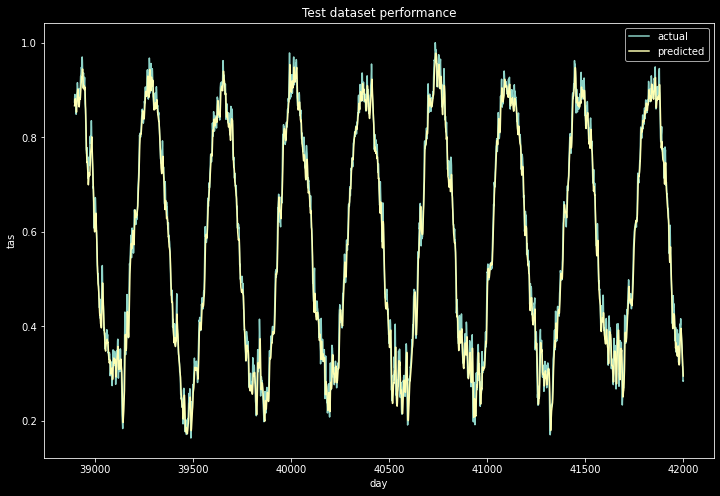

In [41]:
#creating graph comparing predictions and actual values for the test dataset
fc = df.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
plt.figure(figsize=(12, 8))
plt.plot(fc['day'], fc['tas'], label='actual')
plt.plot(fc['day'], fc['forecast'], label='predicted')
plt.xlabel("day")
plt.ylabel("tas")
plt.title("Test dataset performance")
plt.legend()
plt.show()

In [13]:
if SAVE_MODEL := False:
    model.save("lstm")

INFO:tensorflow:Assets written to: lstm\assets


INFO:tensorflow:Assets written to: lstm\assets


In [19]:
if LOAD_FROM_FILE := False:
    # Load model from file
    import keras.models
    model = keras.models.load_model("lstm 1000")
    deep_learner = DeepModelTS(
        data = df,
        Y_var = 'tas',
        lag = 1000,
        LSTM_layer_depth = 50,
        epochs = 10,
        batch_size = 256,
        train_test_split = 0.15
    )
    deep_learner.model = model
    yhat = deep_learner.predict()

In [42]:
#predicting the tas n days ahead
n_ahead = 200
yhat_future = deep_learner.predict_n_ahead(n_ahead)
yhat_future = [y[0][0] for y in yhat_future]

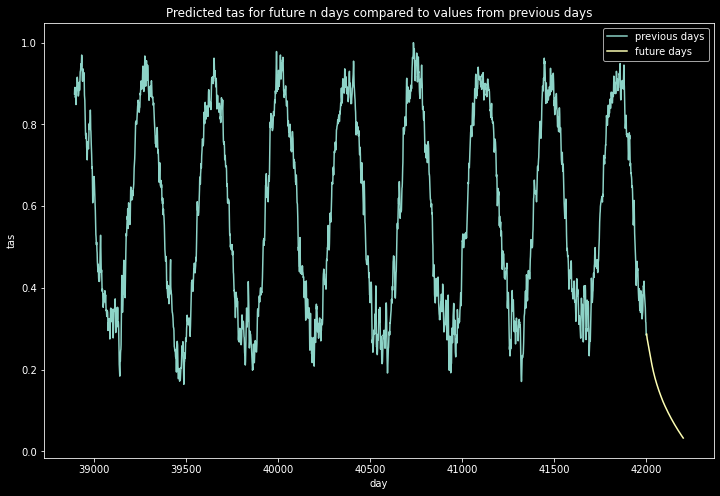

In [43]:
import utilities

import importlib
importlib.reload(utilities)


#creating graph with tas values from previous days AND predicted values for future n days
xDay = []
for i in range(1, n_ahead+1):
    xDay.append(42002+i)
plt.figure(figsize=(12, 8))
plt.plot(fc["day"], fc['tas'], label='previous days')
plt.plot(xDay, yhat_future, label='future days')
# plt.xticks(np.arange(0, len(xDay), step=100))
plt.xlabel("day")
plt.ylabel("tas")
plt.title("Predicted tas for future n days compared to values from previous days")
plt.legend()
plt.show()

IndexError: arrays used as indices must be of integer (or boolean) type

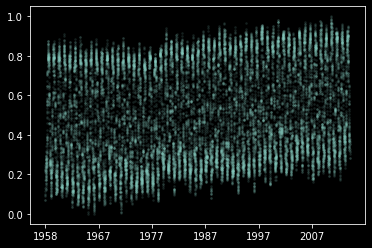

In [44]:
import utilities
import importlib
importlib.reload(utilities)
from utilities import *

fig, ax = plot_temps()
ax.plot(xDay, yhat_future, 'g-')
fig.canvas.draw()
fig.canvas.flush_events()